Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Jake Ford"
COLLABORATORS = ""

---

# Lab 3: parametric B&eacute;zier spline aerofoils and flow simulation
## Task 1: create a parametric B&eacute;zier spline aerofoil
In this task you will write a function <code>parametric_aerofoil(w)</code> that creates a B&eacute;zier spline aerofoil and returns a $201\times 2$ array <code>points</code> of $x,y$ points on the aerofoil from the trailing edge, along the lower surface, round the leading edge, and back along the upper surface to the trailing edge. It should also plot the aerofoil, control points and control polygon. The key difference to Lab 2 is that now the aerofoil shape can be varied by changing paramter <code>w</code>, which controls the weighting $z_u^{(2)}$ of control point $u^{(2)}$.

First you need to import relevant modules:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from aclab1 import rational_bezier

Now you've had a bit of practice, in this lab you'll be writing nearly all the code. Below write the function <code>parametric_aerofoil(w)</code>:

In [6]:
def parametric_aerofoil(w):
    """W is the weight of the point u2"""
    # control points for each curve
    p = np.array([[1, 0.0], [0.5, 0.08], [0.0, -0.05]])
    q = np.array([[0.0, 0.1], [0.4, 0.2], [1, 0.0]])
    # weights
    zp = np.array([1, 1, 1, 1])
    zq = np.array([1, 1, w, 1])
    # calculate degree
    # n and p are the order of p and q respectively
    n = np.float(p.shape[0])
    m = np.float(q.shape[0])
    # calculate connection point
    q_start = p_end = (n / (n + m)) * p[-1,:] + (m / (n + m)) * q[0,:]
    # add to control points
    pp = np.vstack([p, p_end])
    qq = np.vstack([q_start, q])
    # calculate two curves 
    lower = rational_bezier(pp, zp)
    upper = rational_bezier(qq, zq)
    # and join together and remove repeat point
    points = np.concatenate([lower,upper[1:]])

    return points

Check that your function works:

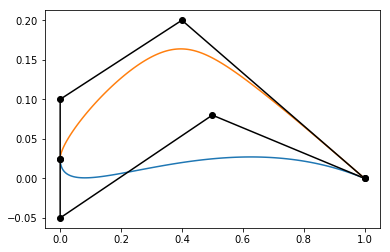

In [7]:
w = 4.0
points=parametric_aerofoil(w)

With $w>1$, the upper surface should be drawn towards $u^{(2)}$. The function should still return 201 points, starting at the trailing edge $l^{(0)}$, passing through the leading edge $l^{(3)}=u^{(0)}$, and ending at the trailing edge $u^{(3)}$:

In [8]:
print(len(points))
print(points[0,:])
print(points[100,:])
print(points[-1,:])

201
[ 1.  0.]
[ 0.     0.025]
[ 1.  0.]


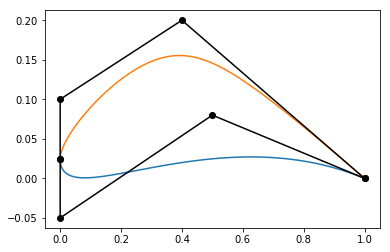

In [9]:
"""Check that parametric_aerofoil returns the correct output for several inputs"""
points = parametric_aerofoil(3)
assert len(points) == 201
assert np.allclose(points[0,:], [1.0, 0.0], 0.0001)
assert np.allclose(points[-1,:], [1.0, 0.0], 0.0001)
assert np.allclose(points[100,:], [0.0, 0.025], 0.0001)
assert np.allclose(points[75,:], [ 0.0859375,   0.00070312], 0.0001)

Check that you can pass the output of this function to <code>vortex_panel</code>:

0.984245700123


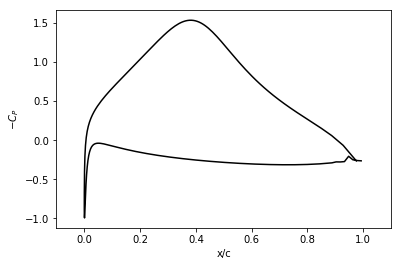

In [10]:
from aclabtools import vortex_panel
[cl, cp, xc] = vortex_panel(points, 0, 1)
print(cl)

## Task 2: find the lift for a range of parameters
In this task you will write a function <code>parameter_sweep(w_array)</code> that creates a range of B&eacute;zier spline aerofoils for different values of $z_u^{(2)}$ difened in <code>w_array</code> and returns an array of associated lift values when the aerofoils are simulated at $\alpha = 0$.

Complete the code for this function below:

In [63]:
def parameter_sweep(w_array):
    clst = []
    for x in w_array:
        pts = parametric_aerofoil(x)
        [cla, cp, xc] = vortex_panel(pts, 0, 0)
        clst.append(cla)
    cla = np.array(clst)
    return cla

And check it works:

[ 0.76517619  0.86402808  0.91328471  0.94173333  0.95433164  0.96869002]


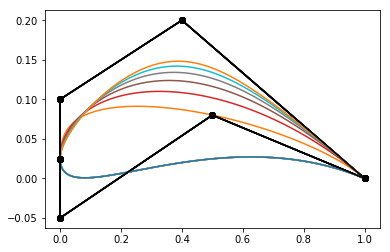

In [64]:
w_array = np.linspace(0.4 ,2.4 ,6)
cl = parameter_sweep(w_array)
print(cl)

The relationship between $z_u^{(2)}$ and $C_L$ may well not be linear so, instead of the first order polynomial you used in the last lab, we'll use a 'moving least squares' fit. The function <code>mls_curve_fit</code> accepts three inputs: an array of $x$ and $y$ values to fit, and an $x$-value at which to make a prediction. It plots the input data, the curve fit, and returns the prediction. Below we'll fit the data you calculated above:

C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.8930564415182487

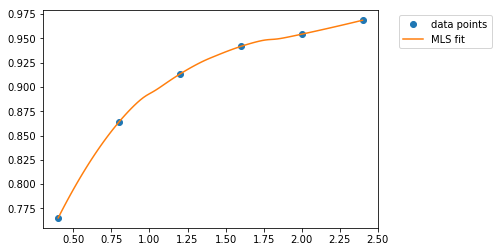

In [65]:
from aclabtools import mls_curve_fit
mls_curve_fit(w_array,cl,1.0)

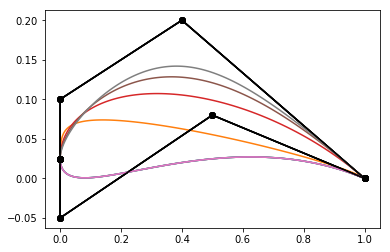

In [66]:
"""Check that parameter_sweep returns the correct output"""
assert np.allclose(parameter_sweep(np.linspace(0.1 ,2.0 ,4)), [0.56581486,  0.85220547,  0.92877433,  0.95433164], 0.0001)

## Task 3: create a fuction to help you find an aerofoil with a desired $C_L$
We wish to find $z_u^{(2)}$ which gives an aerfoil that has $C_L=0.8$ at $\alpha=0$. We could use the plot you produced above to have a good guess at the value for $z_u^{(2)}$. We want to be a bit more precise though so we'll use an optimizer that finds the minimum of a function. For this to work you'll need to create a fucntion that accepts $z_u^{(2)}$ and the target lift  $C_L=0.8$ as inputs and returns a scalar which is at its minimum when the target lift input is achieved. 

Complete the code for this function below:

In [94]:
def fixed_lift(w, alpha, target_cl):
    pts = parametric_aerofoil(w)
    [cl, cp, xc] = vortex_panel(pts, 0, 0)
    a = abs(cl - target_cl)
    return a**2 #should be minimum when cl = target_cl

We can see from the plot above that the answer we're looking for is approximately $z_u^{(2)} = 0.45$, so try this, and the answer should be close to zero:

0.000249781578229


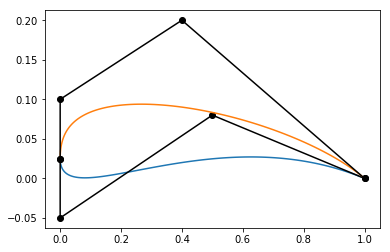

In [95]:
guess = fixed_lift(0.45, 0.0, 0.8)
print(guess)

We can get a better picture of what's going on by re-writing the <code>paramter_sweep</code> function and plotting a moving least squares fit. Complete the code below to calculate the output of <code>fixed_lift</code>, but for a range of $z_u^{(2)}$s in <code>w_array</code>:

In [96]:
def fixed_lift_sweep(w_array, alpha, target_cl):
    clst = []
    for x in w_array:
        clc = fixed_lift(x, alpha, target_cl)
        clst.append(clc)
    a_array = np.array(clst)
    return a_array

Now we'll plot the output of your function, along with a moving least squares fit (it will take a few moments to run <code>vortex_panel</code> this many times):

[  1.73980036e-02   9.39773833e-03   4.86642984e-03   1.88829362e-03
   3.71600023e-04   3.97277639e-07   2.13325665e-04   8.12908259e-04
   1.72052585e-03   2.85941648e-03   4.09959457e-03]


C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.00023574307095427377

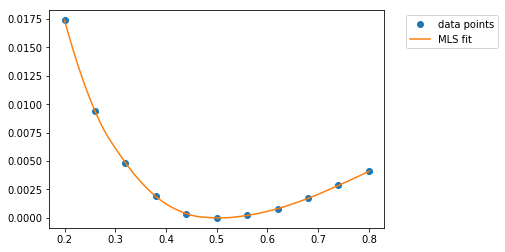

In [97]:
w_array = np.linspace(0.2 ,0.8 ,11)
test_array = fixed_lift_sweep(w_array, 0.0, 0.8)
print(test_array)
pl.clf() #this clears the current plot, so we don't end up plotting our curve over aerofoils
mls_curve_fit(w_array,test_array,0.45)

We'll test your code by checking a point from the moving least squares fit:

In [98]:
"""Check that fixed_lift_sweep returns the correct output"""
assert np.allclose(mls_curve_fit(np.linspace(0.2 ,0.8 ,5),fixed_lift_sweep(np.linspace(0.2 ,0.8 ,5), 0.0, 0.8),0.25), 0.011453, 0.0001)
pl.clf()

C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In the next lab we'll try and get an accurate result by passing the <code>fixed_lift</code> function to an optimizer.

Restart the kernel and run all (click "Kernel", "Restart & Run All"), to make sure everything is working before submitting this .ipynb file via Blackboard. 